# Notebook Capítulo Empírico

Abaixo um roteiro em células de notebook que cobre:

1. Importação de pacotes
2. Carregar os dados JSON
3. Unir datasets (merge por data)
4. Criar retorno mensal do IBOV (%)
5. Estatísticas descritivas
6. Gráficos comparativos
7. Regressão Linear Simples (modelo principal)
8. Gráfico de dispersão com linha de regressão
9. Análise complementar: SELIC Meta (% a.a.)


## 0. Extrair e preparar os dados

In [ ]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from ibovselic import MarketDataExporter

output_dir = PROJECT_ROOT / "data" / "raw"
output_dir.mkdir(parents=True, exist_ok=True)

inicio_analise = 2009
fim_analise = 2024

exporter = MarketDataExporter(data_dir=output_dir)

exporter.export_selic_meta(inicio_analise, fim_analise)
exporter.export_selic(inicio_analise, fim_analise)
exporter.export_ibov(inicio_analise, fim_analise)


[2025-10-27 20:00:45] [INFO] Iniciando exportação de SELIC Meta (BACEN) (2009-2024)
[2025-10-27 20:00:45] [INFO] Baixando SELIC Meta (BACEN): 2009 → 2018
[2025-10-27 20:00:46] [INFO] Baixando SELIC Meta (BACEN): 2019 → 2024
[2025-10-27 20:00:47] [INFO] ✅ Arquivo salvo em: C:\Users\crist\Documents\projetos\py_selic_ibov\app\notebooks\dados_exportados\history_selic_meta.json
[2025-10-27 20:00:47] [INFO] Iniciando exportação de SELIC (BACEN - Mensal) (2009-2024)
[2025-10-27 20:00:47] [INFO] Baixando SELIC (BACEN - Mensal): 2009 → 2018
[2025-10-27 20:00:48] [INFO] Baixando SELIC (BACEN - Mensal): 2019 → 2024
[2025-10-27 20:00:48] [INFO] ✅ Arquivo salvo em: C:\Users\crist\Documents\projetos\py_selic_ibov\app\notebooks\dados_exportados\history_selic.json
[2025-10-27 20:00:48] [INFO] Iniciando exportação de IBOVESPA (2009-2024)
[2025-10-27 20:00:48] [INFO] Baixando IBOVESPA: 2009 → 2018
[2025-10-27 20:00:49] [INFO] Baixando IBOVESPA: 2019 → 2024
[2025-10-27 20:00:49] [INFO] ✅ Arquivo salvo em

WindowsPath('dados_exportados/history_ibov.json')

## 1. Importação de pacotes

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


## 2. Carregar os dados JSON

In [4]:
ibov = pd.read_json(pasta_arquivos / "history_ibov.json")               # Ibov Acumulado
selic = pd.read_json(pasta_arquivos / "history_selic.json")             # acumulada % a.m.
selic_meta = pd.read_json(pasta_arquivos / "history_selic_meta.json")   # meta % a.a.

# Converter datas
for df in [ibov, selic, selic_meta]:
    df["date_reference"] = pd.to_datetime(df["date_reference"])

# Renomear colunas de valor
ibov = ibov.rename(columns={"value": "ibov"})
selic = selic.rename(columns={"value": "selic_mensal"})
selic_meta = selic_meta.rename(columns={"value": "selic_meta"})


## 3. Unir datasets (merge por data)

In [5]:
df = (
    ibov[["date_reference","ibov"]]
    .merge(selic[["date_reference","selic_mensal"]], on="date_reference")
    .merge(selic_meta[["date_reference","selic_meta"]], on="date_reference")
)

df.head(10)


,date_reference,ibov,selic_mensal,selic_meta
0,2009-01-01,39300.79,1.05,13.26
1,2009-02-01,38183.31,0.86,12.62
2,2009-03-01,40925.87,0.97,11.65
3,2009-04-01,47289.53,0.84,11.05
4,2009-05-01,53197.73,0.77,10.10
5,2009-06-01,51465.46,0.76,9.40
6,2009-07-01,54765.72,0.79,8.93
7,2009-08-01,56488.98,0.69,8.62
8,2009-09-01,61517.89,0.69,8.62
9,2009-10-01,61545.50,0.69,8.62


## 4. Criar retorno mensal do IBOV (%)

In [8]:
df["ibov_return"] = df["ibov"].pct_change() * 100
df = df.dropna().reset_index(drop=True)

df.head()


,date_reference,ibov,selic_mensal,selic_meta,ibov_return
0,2009-02-01,38183.31,0.86,12.62,-2.843403
1,2009-03-01,40925.87,0.97,11.65,7.182615
2,2009-04-01,47289.53,0.84,11.05,15.549236
3,2009-05-01,53197.73,0.77,10.10,12.493675
4,2009-06-01,51465.46,0.76,9.40,-3.256286


## 5. Estatísticas descritivas

In [11]:
print(df[["ibov","ibov_return","selic_mensal","selic_meta"]].describe())

# Correlação
print("\nCorrelação:")
print(df[["ibov","ibov_return","selic_mensal","selic_meta"]].corr())


                ibov  ibov_return  selic_mensal  selic_meta
count     191.000000   191.000000    191.000000  191.000000
mean    79440.877874     0.782221      0.754660    9.493037
std     27308.688385     6.202850      0.265682    3.381905
min     38183.310000   -29.904330      0.130000    1.900000
25%     56290.735000    -3.293862      0.550000    6.950000
50%     67705.400000     0.645050      0.800000   10.320000
75%    104783.880000     4.842147      0.950000   12.070000
max    136004.010000    16.968345      1.220000   14.140000

Correlação:
                  ibov  ibov_return  selic_mensal  selic_meta
ibov          1.000000     0.059914     -0.282217   -0.279058
ibov_return   0.059914     1.000000     -0.021278   -0.017868
selic_mensal -0.282217    -0.021278      1.000000    0.981174
selic_meta   -0.279058    -0.017868      0.981174    1.000000


## 6. Gráficos comparativos

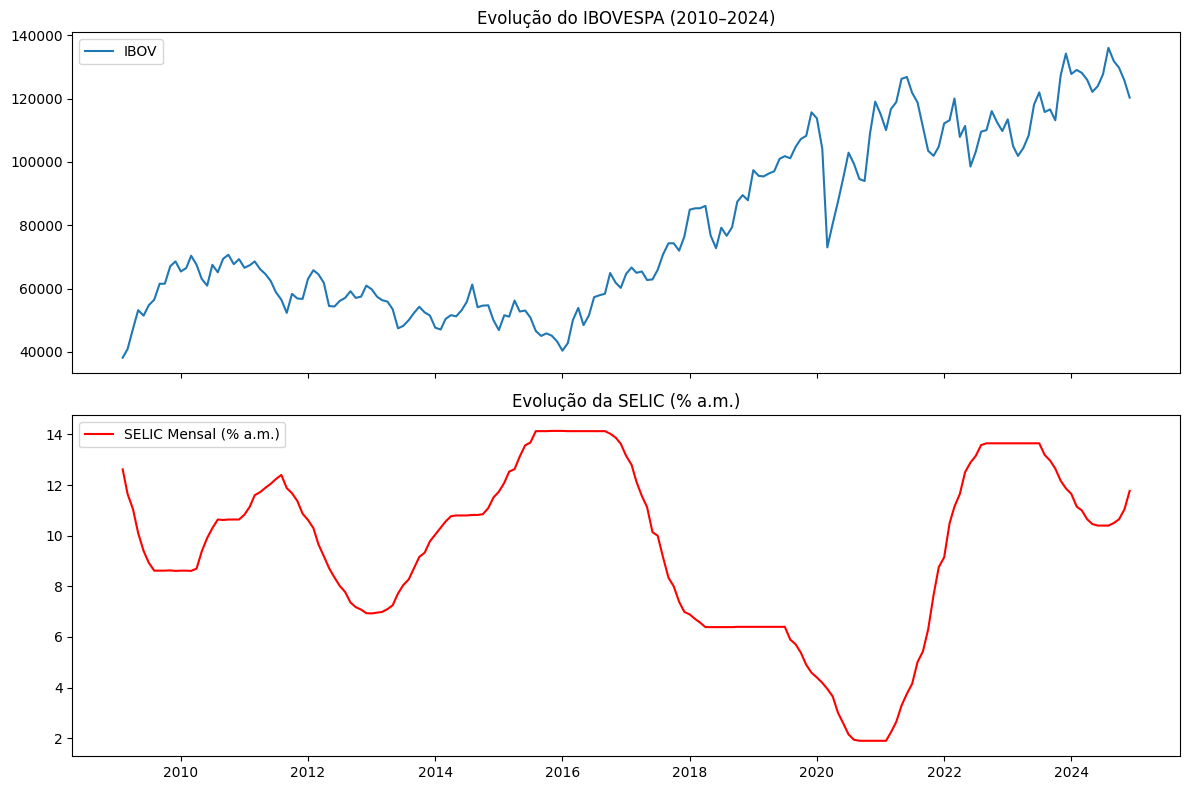

In [22]:
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)

# Série IBOV vs SELIC
ax[0].plot(df["date_reference"], df["ibov"], label="IBOV")
ax[0].set_title("Evolução do IBOVESPA (2010–2024)")
ax[0].legend()

ax[1].plot(df["date_reference"], df["selic_meta"], label="SELIC Mensal (% a.m.)", color="red")
ax[1].set_title("Evolução da SELIC (% a.m.)")
ax[1].legend()

plt.tight_layout()
plt.show()


## 7. Regressão Linear Simples (modelo principal)

In [25]:
X = sm.add_constant(df["selic_meta"])  # regressora
y = df["ibov"]                    # dependente

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                   ibov   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     15.96
Date:                Mon, 27 Oct 2025   Prob (F-statistic):           9.26e-05
Time:                        20:14:02   Log-Likelihood:                -2213.8
No. Observations:                 191   AIC:                             4432.
Df Residuals:                     189   BIC:                             4438.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.008e+05   5682.329     17.745      0.0

## 8. Gráfico de dispersão com linha de regressão

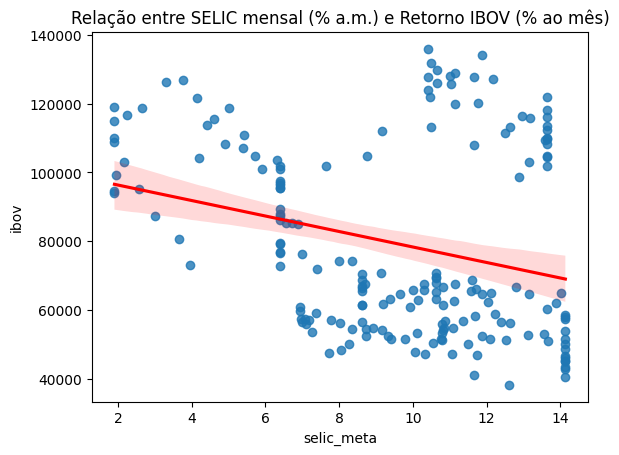

In [27]:
sns.regplot(x="selic_meta", y="ibov", data=df, ci=95, line_kws={"color":"red"})
plt.title("Relação entre SELIC mensal (% a.m.) e Retorno IBOV (% ao mês)")
plt.show()